In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20',
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [5]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.004744,0.000491,0.003217,0.003817,0.008907,0.018682,0.008956,-0.009838
2005-02-01,-0.005666,-0.000115,-0.000530,-0.002013,0.006112,0.013754,0.006425,-0.003549
2005-02-02,0.004748,-0.000220,0.001214,0.005939,0.004995,0.006156,0.003192,0.002612
2005-02-03,-0.010397,-0.001690,0.000378,-0.003342,-0.007119,0.010988,-0.001758,-0.012077
2005-02-04,0.006686,0.005762,0.013300,0.005588,0.008929,0.016426,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.007921,-0.002991,-0.008365,0.018978,-0.000381,0.012039,-0.005157,0.009863
2024-12-10,-0.006082,-0.002112,-0.005163,-0.016139,-0.009207,0.002292,-0.002896,0.013155
2024-12-11,0.013895,-0.002776,-0.009999,-0.001268,0.004358,0.015587,0.007707,0.009247


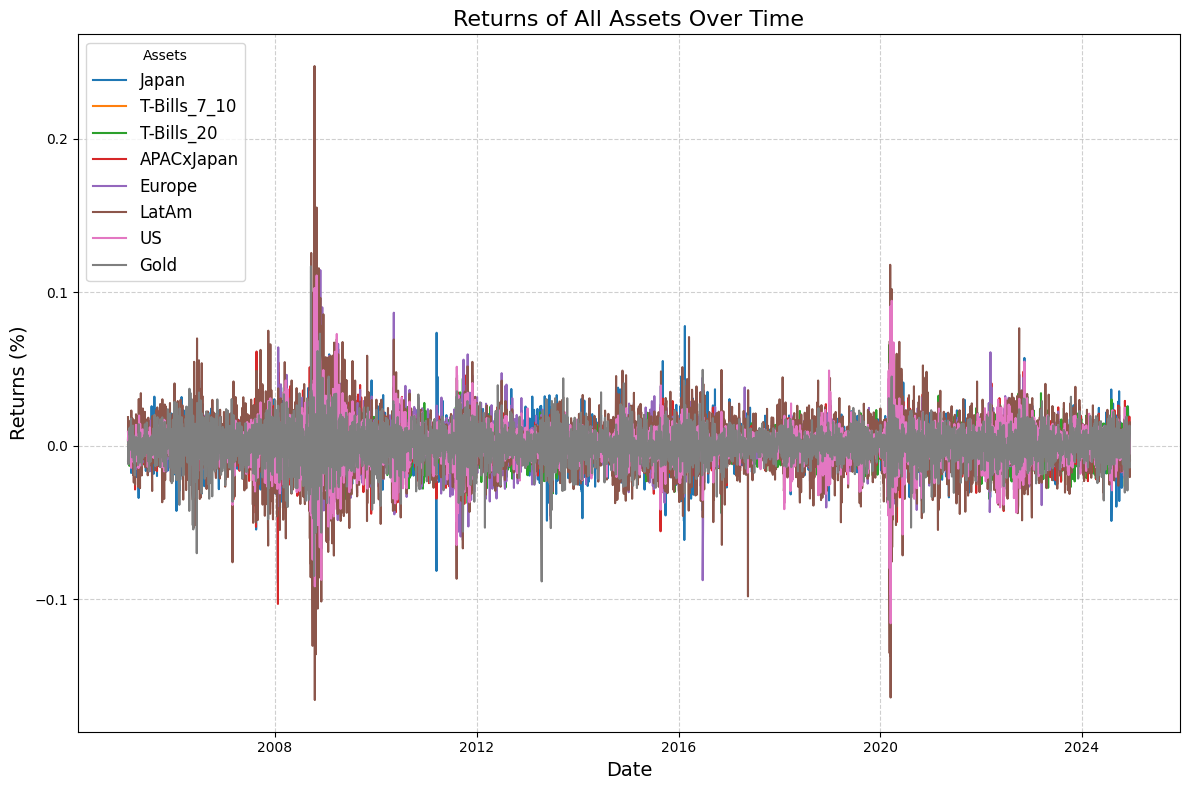

In [6]:
# Plot returns for all assets
plt.figure(figsize=(12, 8))  # Set the figure size
for column in returns.columns:
    plt.plot(returns.index, returns[column], label=column)  # Plot each asset's returns

# Add labels, title, and legend
plt.title("Returns of All Assets Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Returns (%)", fontsize=14)
plt.legend(title="Assets", fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

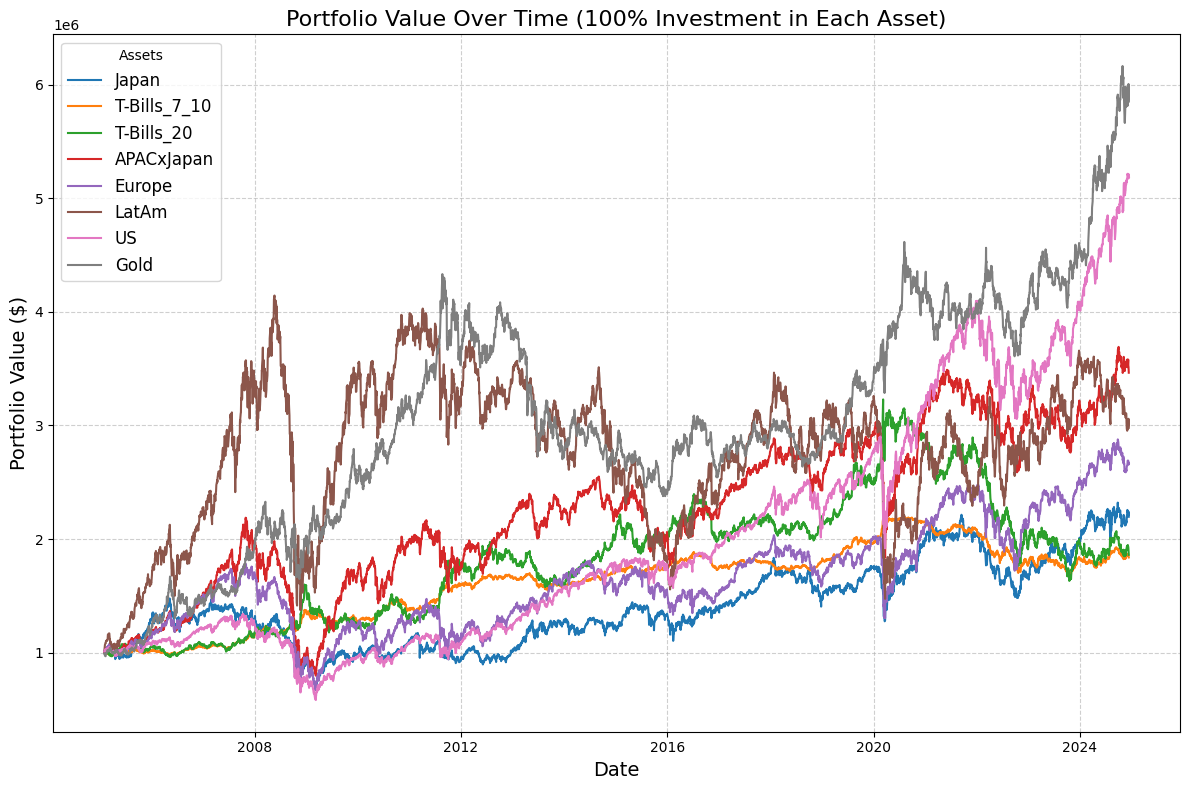

In [7]:

# Set initial investment
initial_investment = 1_000_000  # $1,000,000

# Create a DataFrame to hold portfolio values
portfolio_values = pd.DataFrame(index=returns.index)

# Calculate portfolio value for each asset
for asset in returns.columns:
    # Cumulative returns: (1 + daily return) multiplied sequentially
    portfolio_values[asset] = initial_investment * (1 + returns[asset]).cumprod()

# Plot portfolio values over time
plt.figure(figsize=(12, 8))
for column in portfolio_values.columns:
    plt.plot(portfolio_values.index, portfolio_values[column], label=column)

# Add labels, title, and legend
plt.title("Portfolio Value Over Time (100% Investment in Each Asset)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Portfolio Value ($)", fontsize=14)
plt.legend(title="Assets", fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


In [28]:
def calculate_portfolio_analytics(portfolio_value, asset_name):
    """
    Function to calculate portfolio analytics for a given portfolio value time series.
    """
    # 1) Resample to monthly frequency and calculate monthly returns
    monthly_portfolio_value = portfolio_value.resample('ME').ffill()
    monthly_returns = monthly_portfolio_value.pct_change().dropna()

    # 2) Full sample annualized monthly volatility
    full_sample_monthly_vol = monthly_returns.std()
    annualized_vol = full_sample_monthly_vol * np.sqrt(12)

    # 3) Total return & Geo means
    initial_val = portfolio_value.iloc[0]
    final_val = portfolio_value.iloc[-1]
    total_return = (final_val - initial_val) / initial_val

    n_months = len(monthly_returns)
    geo_avg_monthly_return = (final_val / initial_val) ** (1 / n_months) - 1
    geo_avg_yearly_return = (1 + geo_avg_monthly_return) ** 12 - 1

    # 4) Sharpe Ratio
    arithmetic_monthly_return = monthly_returns.mean()  # Arithmetic mean of monthly returns
    annualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualized arithmetic return
    sharpe_ratio = annualized_arithmetic_return / annualized_vol

    # 5) Monthly 99% VaR
    VaR_99 = monthly_returns.quantile(1 - 0.99)

    # Return the results as a dictionary
    return {
        "Asset": asset_name,
        "Annualized Volatility": annualized_vol,
        "Total Return (%)": total_return * 100,
        "Geometric Monthly Return (%)": geo_avg_monthly_return * 100,
        "Geometric Yearly Return (%)": geo_avg_yearly_return * 100,
        "Sharpe Ratio": sharpe_ratio,
        "99% Monthly VaR": VaR_99,
    }


# Loop through each asset and calculate analytics
analytics_results = []

for asset in returns.columns:
    # Construct individual portfolio value
    portfolio_value = initial_investment * (1 + returns[asset]).cumprod()

    # Calculate analytics
    analytics = calculate_portfolio_analytics(portfolio_value, asset)
    analytics_results.append(analytics)

# Convert results to a DataFrame for easy comparison
analytics_df = pd.DataFrame(analytics_results)

# Display the analytics table
print(analytics_df)

# Optionally, save to a CSV for analysis
analytics_df.to_csv("portfolio_analytics_comparison.csv", index=False)


          Asset  Annualized Volatility  Total Return (%)  \
0         Japan               0.152796         64.164306   
1  T-Bills_7_10               0.065688          9.335979   
2    T-Bills_20               0.137807         -1.701014   
3    APACxJapan               0.207825         54.134310   
4        Europe               0.187738         46.569422   
5         LatAm               0.277859         46.835443   
6            US               0.150602        414.052288   
7          Gold               0.166777        491.199432   

   Geometric Monthly Return (%)  Geometric Yearly Return (%)  Sharpe Ratio  \
0                      0.207620                     2.520089      0.239848   
1                      0.037352                     0.449150      0.100869   
2                     -0.007178                    -0.086104      0.061712   
3                      0.181191                     2.196089      0.210341   
4                      0.160098                     1.938187      0.1